In [1]:


import os
import numpy as np
import torch
from torch.utils.data import Dataset, random_split, TensorDataset
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torchvision.transforms as T

from dendritic_modeling.synthetic_datasets import (
    LineDataset,
    CenterSurroundDataset,
    OrientationBarsDataset,
    MultiXORDataset,
    load_mnist_as_datasets,
    InfoShuntingDataset,
    NoisyLineDataset,
    SparseMNISTDataset,
    ContextualFigureGroundMNIST,
    MultiTaskLineDataset,
    CompositionalMNIST,
    get_unified_datasets
)
#



########################################
# Helper function: plot a single sample if 2D shape
########################################
def show_image_sample(flat_tensor, label, image_size=10):
    """
    Reshapes 'flat_tensor' into (image_size, image_size) 
    and shows it in a matplotlib figure with 'label' as title.
    """
    arr = flat_tensor.numpy().reshape(image_size, image_size)
    plt.imshow(arr, cmap='gray', vmin=0, vmax=1)
    plt.title(f"Label = {label}")
    plt.axis('off')
    plt.show()



## 1) LINE DATASET EXAMPLE ##
Sample 3 => label=0


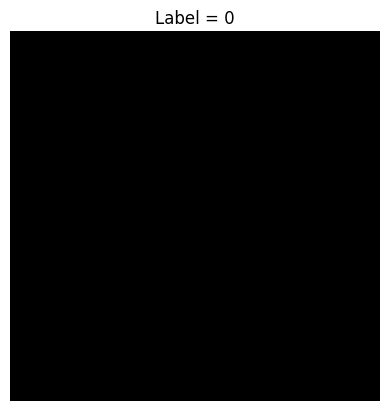

Sample 4 => label=1


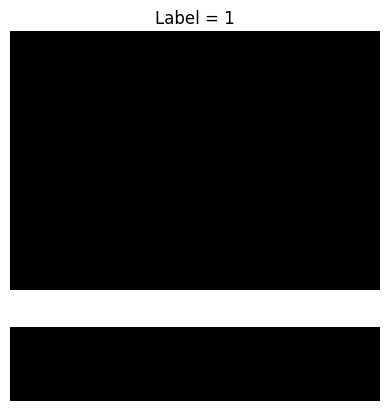

Sample 6 => label=2


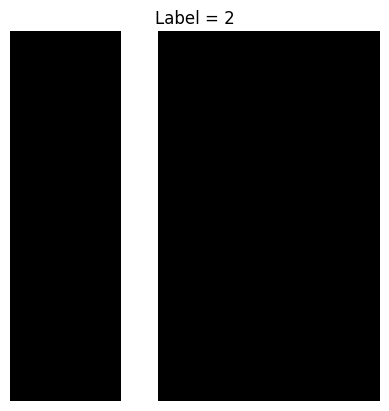

In [2]:

########################################
# 1) Demonstrate dataset usage: line
########################################
print("## 1) LINE DATASET EXAMPLE ##")
line_ds = LineDataset(n_samples=30, image_size=10)  # small sample
n =0
for i in range(30):
    x,y = line_ds[i]
    if y % 3 == n:
        n += 1
        print(f"Sample {i} => label={y}")
        show_image_sample(x, y, image_size=10)


## 2) CENTER_SURROUND EXAMPLE ##
Sample 0 => label=0


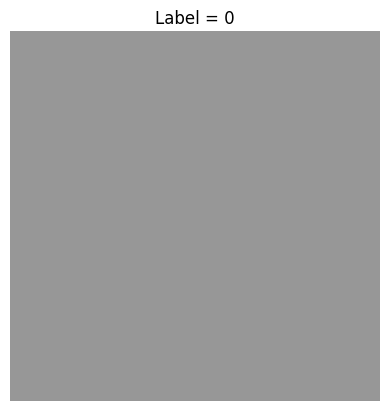

Sample 2 => label=1


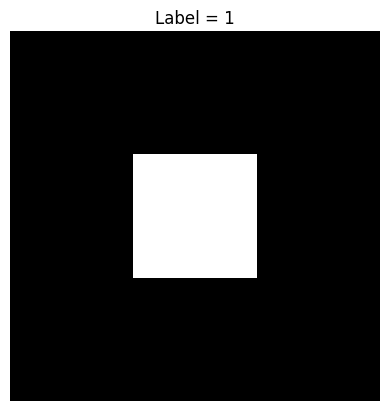

Sample 6 => label=2


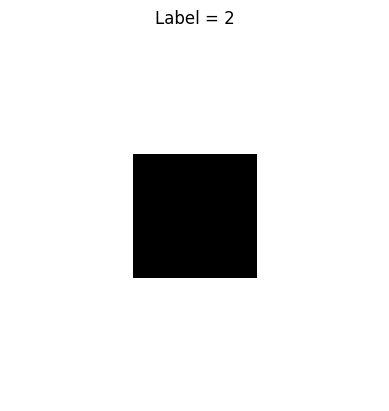

In [3]:

########################################
# 2) center_surround
########################################
print("## 2) CENTER_SURROUND EXAMPLE ##")
cs_ds = CenterSurroundDataset(n_samples=30, image_size=15)
n =0
for i in range(30):
    x,y = cs_ds[i]
    if y % 3 == n:
        n += 1
        print(f"Sample {i} => label={y}")
        show_image_sample(x, y, image_size=15)


## 3) ORIENTATION_BARS EXAMPLE ##
Sample 2 => label=0


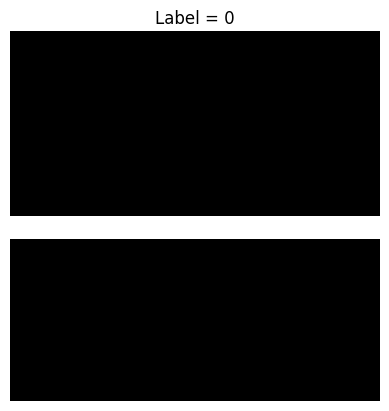

Sample 20 => label=1


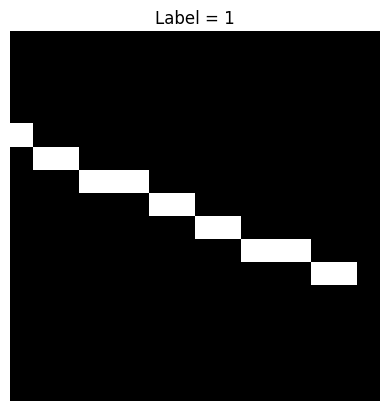

Sample 24 => label=2


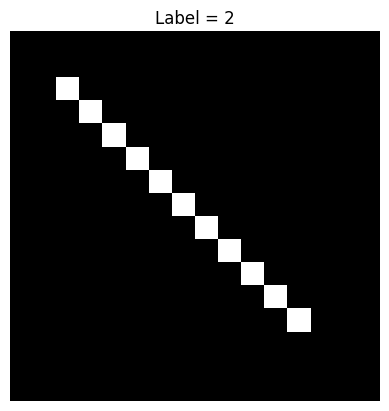

Sample 36 => label=3


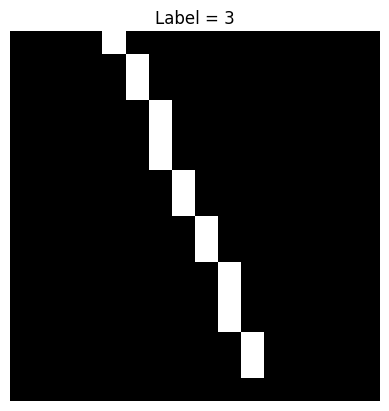

Sample 88 => label=4


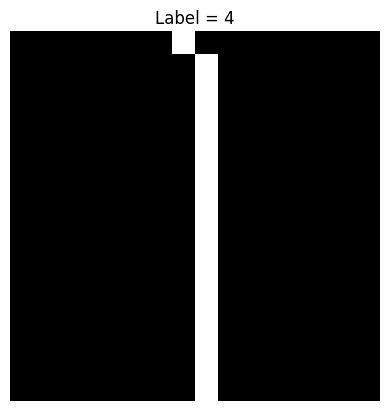

Sample 99 => label=5


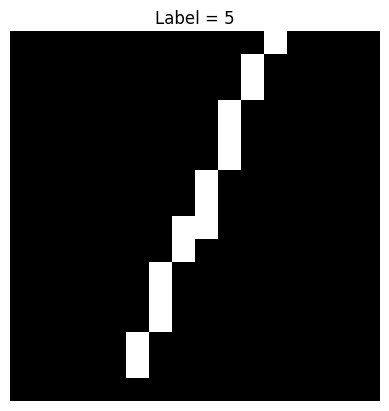

Sample 104 => label=6


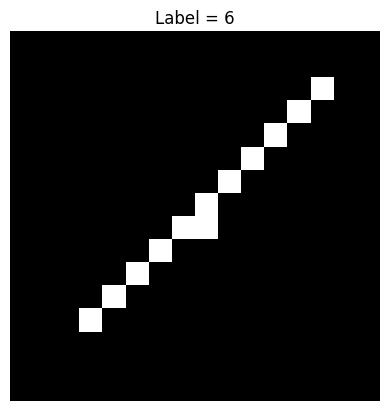

Sample 109 => label=7


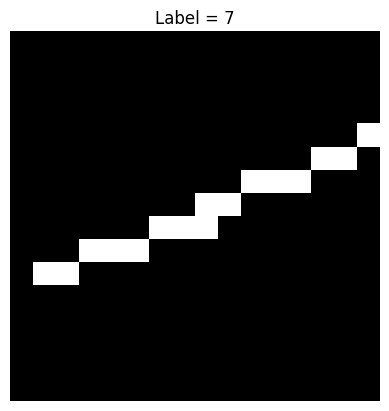

In [4]:
########################################
# 3) orientation_bars
########################################
print("## 3) ORIENTATION_BARS EXAMPLE ##")
bars_ds = OrientationBarsDataset(n_samples=300, image_size=16, n_orient_classes=8)
n =0
for i in range(300):
    x,y = bars_ds[i]
    if y % 8 == n:
        n += 1
        print(f"Sample {i} => label={y}")
        show_image_sample(x, y, image_size=16)

In [5]:

########################################
# 4) multi_xor
########################################
print("## 4) MULTI_XOR EXAMPLE ##")
xor_ds = MultiXORDataset(n_samples=5, n_bits=8)
for i in range(5):
    x,y = xor_ds[i]
    print(f"bits = {x.numpy()}, label = {y}")



## 4) MULTI_XOR EXAMPLE ##
bits = [1 0 0 1 0 1 0 0], label = 3
bits = [0 1 0 0 1 0 0 0], label = 3
bits = [0 0 0 1 1 0 0 1], label = 0
bits = [1 1 1 0 1 1 0 0], label = 0
bits = [1 1 0 0 1 1 1 0], label = 1


In [6]:
########################################
# 5) MNIST (load a small subset)
########################################
print("## 5) MNIST EXAMPLE ##")
train_ds, valid_ds, test_ds = load_mnist_as_datasets(train_valid_split=0.8)
print(f"Full MNIST train size = {len(train_ds)}")

# Let's show the first item 
x,y = train_ds[0]
print("Shape of x:", x.shape, "label:", y)




## 5) MNIST EXAMPLE ##
Full MNIST train size = 48000
Shape of x: torch.Size([784]) label: tensor(5)


In [7]:
########################################
# 6) "New tasks" e.g. info_shunting
########################################
print("## 6) INFO_SHUNTING EXAMPLE ##")
info_ds = InfoShuntingDataset(n_samples=10, input_dim=10)
for i in range(5):
    x,y = info_ds[i]
    print(f"sample i={i}, x={x.numpy()}, label={y}")



## 6) INFO_SHUNTING EXAMPLE ##
sample i=0, x=[-0.1161925   0.62611973 -0.07926004 -0.11867868 -0.9234953  -0.956911
 -0.9241428   0.7577379  -0.3943935   0.38728213], label=1
sample i=1, x=[ 0.19290915 -0.7961681  -0.5689398  -0.80399525  0.34776643 -0.50884354
  0.38935     0.3287187   0.440763    0.48874807], label=1
sample i=2, x=[ 0.46637177  0.4927978  -0.46296728  1.4931921  -1.0250345  -1.516848
  1.154243   -2.0607939   1.7927155  -1.9861714 ], label=0
sample i=3, x=[-0.1715247  -1.4755428   0.98934454 -0.920978    0.26603585 -0.7029515
 -0.22693203 -0.8147461   1.6805527  -0.210763  ], label=0
sample i=4, x=[ 1.5368553  -0.950055   -0.93953353  1.2513647  -0.12955607 -1.192651
  0.5802019   1.4728855   2.3227055   0.14097136], label=0


In [8]:
########################################
# ... Similarly for NoisyLineDataset, etc.
########################################



########################################
# 7) Quick training example with a small MLP
########################################

class SimpleMLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)
    def predict(self, x):
        logits = self.forward(x)
        return logits.argmax(dim=-1)

def train_simple_mlp(dataset, input_dim=100, output_dim=3, hidden_dim=50, epochs=5, batch_size=32):
    # We'll do a 80/20 split manually
    n_total = len(dataset)
    n_train = int(n_total*0.8)
    n_valid = n_total-n_train
    train_ds, valid_ds = random_split(dataset, [n_train, n_valid])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SimpleMLP(input_dim, hidden_dim, output_dim).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, epochs+1):
        model.train()
        total_loss=0
        for xb,yb in train_loader:
            xb=xb.to(device)
            yb=yb.to(device)
            optimizer.zero_grad()
            out=model(xb)
            loss=criterion(out,yb)
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()
        total_loss/=len(train_loader)

        # validation
        model.eval()
        val_loss=0
        correct=0
        total=0
        with torch.no_grad():
            for xb,yb in valid_loader:
                xb=xb.to(device)
                yb=yb.to(device)
                out=model(xb)
                loss=criterion(out,yb)
                val_loss+=loss.item()
                preds=out.argmax(dim=-1)
                correct+=(preds==yb).sum().item()
                total+=yb.size(0)
        val_loss/=len(valid_loader)
        acc=correct/total
        print(f"Epoch {epoch}/{epochs}, train_loss={total_loss:.4f}, val_loss={val_loss:.4f}, val_acc={acc:.3f}")

    return model


print("\n### Quick test: train on the line dataset ###")
line_ds_small = LineDataset(n_samples=500, image_size=10)
model = train_simple_mlp(line_ds_small, input_dim=10*10, output_dim=3, hidden_dim=50, epochs=5, batch_size=32)

print("Done. We can check final performance on entire line_ds_small.")


### Quick test: train on the line dataset ###


NameError: name 'DataLoader' is not defined

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Simulating a 3-layer network's activations during pretraining
num_samples = 100  # Number of samples
num_classes = 4  # Simulating a 4-class problem
layer_sizes = [8, 5, 3]  # Simulating activations in 3 layers (input, hidden, output)

# Generating activations (randomly initialized and aligning towards class labels)
np.random.seed(42)
layer1_activations = np.random.rand(num_samples, layer_sizes[0])  # Input layer (random features)
layer2_activations = np.tanh(layer1_activations @ np.random.randn(layer_sizes[0], layer_sizes[1]))  # Hidden layer
layer3_activations = np.tanh(layer2_activations @ np.random.randn(layer_sizes[1], layer_sizes[2]))  # Output layer

# Simulating target labels (one-hot encoded)
labels = np.random.randint(0, num_classes, num_samples)
y_onehot = np.zeros((num_samples, num_classes))
y_onehot[np.arange(num_samples), labels] = 1

# Compute similarity between activations and one-hot labels at each layer
layer1_similarity = np.mean(np.abs(layer1_activations[:, :num_classes] - y_onehot), axis=1)
layer2_similarity = np.mean(np.abs(layer2_activations[:, :num_classes] - y_onehot), axis=1)
layer3_similarity = np.mean(np.abs(layer3_activations[:, :num_classes] - y_onehot), axis=1)

# Plotting the progression of information alignment
plt.figure(figsize=(8, 5))
plt.plot(layer1_similarity, label="Layer 1 (Input)", alpha=0.7)
plt.plot(layer2_similarity, label="Layer 2 (Hidden)", alpha=0.7)
plt.plot(layer3_similarity, label="Layer 3 (Output)", alpha=0.7)

plt.xlabel("Sample Index")
plt.ylabel("Activation - Label Alignment (L1 Distance)")
plt.title("Alignment of Activations to One-Hot Labels Across Layers")
plt.legend()
plt.show()


ValueError: operands could not be broadcast together with shapes (100,3) (100,4) 